# Projeto 3 Ciência dos Dados - Mercado Imobiliário

Grupo 1 / 2C

Arthur Carvalho, Fernando Bichuette, Guilherme Lunetta, Rafael Kahn.



## Pergunta

        Como podemos classificar imóveis da cidade de São Paulo por padrão de vida utilizando técnicas obtidas ao longo do       semestre? 

## Motivação/Introdução


        O mercado imobiliário é o mercado que trata de qualquer venda relacionada à propriedade e ao terreno no qual este está inserido. Dito isso, é razoável inferir que este é um dos grandes setores da economia de qualquer local desenvolvido. No contexto do Brasil, é inegável dizer que o lugar com maior potencial de liquidez do mercado imobiliário é São Paulo. Porém, em uma cidade de tal dimensão e com suas complexidades e características intrínsecas a si, é difícil fazer uma   análise do mercado imobiliário apenas partindo do senso comum e de técnicas obsoletas. Assim, o grupo 1 do projeto 3 de ciência dos dados decide fazer uma análise exploratória e utilizar a técnica de classificação random forest para estudar o mercado imobiliário de São Paulo. O resultado do projeto está disponível abaixo.



## Random Forest

        Random forest é uma técnica de classificação e regressão que utiliza de diversas árvores de escolha para formular uma decisão. Nesse método, a base de dados é separada em treinamento e teste, onde o treinamento utiliza uma amostra      aleatória de dados da base, nesse caso imóveis, para perceber padrões entre as variáveis atribuidas ao dado. Feito isso, o método é aplicado no teste, fazendo a mesma coisa que na base treinamento. Para o trabalho, será utilizado a parte da técnica relativa à classificação.

In [4]:
#Começar por importar as bibliotecas necessárias

%matplotlib inline
%reset -f
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, uniform, probplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import mpl_toolkits
from sklearn.tree import export_graphviz

In [5]:
#Definir seed
RANDOM_SEED = 152
np.random.seed(RANDOM_SEED)


In [6]:
#Abrindo a base de dados

data = pd.read_csv("sao-paulo-properties-april-2019.csv")
data.drop(data.columns[[15, 14]], axis=1, inplace=True)

# Limitar a análise para somente vendas

data = data[data['Negotiation Type'] == 'sale']
data.head()


,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment


In [7]:
#Zonas de São Paulo

zona_sul = ['Campo Limpo', 'Capão Redondo', 'Vila Andrade', 'Cidade Dutra', 'Grajaú', 'Socorro', 'Cidade Ademar', 'Pedreira', 'Ipiranga', 'Sacomã', 'Jabaquara', "M'Boi Mirim", 'Jardim Ângela', 'Jardim Sao Luis', 'Parelheiros', 'Marsilac', 'Santo Amaro', 'Campo Belo', 'Campo Grande', 'Moema', 'Saúde', 'Vila Mariana', 'Brooklin', 'Vila Olimpia', 'Cursino', 'Jardim São Luis']
zona_leste = ['Aricanduva', 'Carrão', 'Vila Formosa', 'Cidade Tiradentes', 'Ermelino Matarazzo', 'Ponte Rasa', 'Guaianases', 'Lajeado', 'Itaim Paulista', 'Vila Curuça', 'Itaquera', 'Cidade Lider', 'José Bonifácio', 'Parque do Carmo', 'Mooca Água Rasa', 'Belém', 'Brás', 'Mooca', 'Pari', 'Tatuapé', 'Penha', 'Artur Alvim', 'Cangaíba', 'Penha', 'Vila Matilde', 'São Mateus', 'São Rafael', 'São Miguel', 'Jardim Helena', 'Vila Jacuí', 'Sapopemba', 'Vila Prudente', 'São Lucas', 'Água Rasa', 'Vila Curuçá', 'Cidade Líder', 'Guaianazes', 'Iguatemi'] 
zona_oeste = ['Butantã', 'Morumbi', 'Raposo Tavares', 'Rio Pequeno', 'Vila Sônia', 'Lapa', 'Barra Funda', 'Jaguara', 'Jaguaré', 'Perdizes', 'Vila Leopoldina', 'Pinheiros', 'Alto de Pinheiros', 'Itaim Bibi', 'Jardim Paulista', 'Pinheiros', 'Vila Madalena']
zona_norte = ['Casa Verde', 'Cachoeirinha', 'Limão', 'Brasilândia', 'Freguesia do Ó', 'Jaçanã', 'Tremembé', 'Perus', 'Anhanguera', 'Pirituba', 'Jaraguá', 'São Domingos', 'Santana', 'Tucuruvi', 'Mandaqui', 'Vila Maria', 'Vila Guilherme', 'Vila Medeiros', 'Medeiros']
centro = ['Sé Bela Vista', 'Bela Vista', 'Bom Retiro', 'Cambuci', 'Consolação', 'Liberdade', 'República', 'Santa Cecília', 'Sé']

In [8]:
#Tirando /São Paulo dos bairros

filtro = data.District.str.replace('/São Paulo', '')
filtro
data.District = filtro


In [9]:
#Adicionando zonas em função dos bairros para cada item do DataFrame

data.loc[(data.District).isin (zona_sul), 'Zone'] = 'ZS'
data.loc[(data.District).isin (zona_leste), 'Zone'] = 'ZL'
data.loc[(data.District).isin (zona_oeste), 'Zone'] = 'ZO'
data.loc[(data.District).isin (zona_norte), 'Zone'] = 'ZN'
data.loc[(data.District).isin (centro), 'Zone'] = 'Centro'


In [10]:
#Novo data.head(), agora filtrado conforme as zonas da cidade

data.head()


,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Zone
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena,sale,apartment,ZO
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena,sale,apartment,ZO
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena,sale,apartment,ZO
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena,sale,apartment,ZO
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena,sale,apartment,ZO


In [11]:
data.describe()


,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New
count,6.412000e+03,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,6.086241e+05,537.349813,78.611042,2.320805,2.037742,0.931535,1.326575,0.415471,0.117280,0.539457,0.032283
std,7.404515e+05,624.632473,50.872359,0.714743,0.917844,0.772615,0.751658,0.492841,0.321779,0.498480,0.176765
min,4.200000e+04,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500000e+05,150.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3.800000e+05,400.000000,62.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,6.790000e+05,700.000000,87.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000e+07,8920.000000,620.000000,6.000000,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000


## Análise Explorativa

Vale lembrar que o target da análise é o preço do imóvel



### Price x Condo


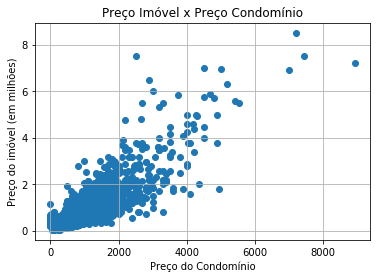

In [12]:
plt.scatter(data['Condo'][data['Condo']!=0], data['Price'][data['Condo']!=0]/1000000)
plt.xlabel('Preço do Condomínio')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x Preço Condomínio')
plt.grid(True)
plt.show()


In [13]:
data['Price'].corr(data['Condo'])

0.6144562283005393

* Por esse gráfico podemos analisar que o preço do condomínio tem uma influência razoável no preço do imóvel. Existem outliers significantes que podreão ser desconsiderados. Analisando também a correlação, é possível dizer que o Preço do Condomínio é significante para nosso trabalho


### Price x Size

In [14]:
a = data["Price"]/1000000

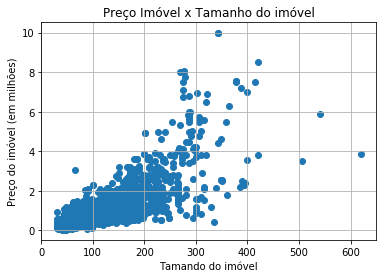

In [15]:
x1 = data['Size']
y1 = a
plt.xlabel('Tamando do imóvel')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x Tamanho do imóvel')
plt.scatter(x1,y1)
plt.grid(True)

In [16]:
x1.corr(y1)

0.8256597461587776

* A partir desse gráfico, pode-se observar que o tamanho do imóvel tem grande influência no preço do imóvel, com uma correlação de 0.82 e pouquíssimos outliers. Com certeza entra na lista de variáveis significantes


### Price x Toilets

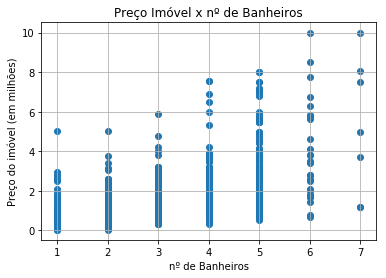

In [17]:
plt.scatter(data['Toilets'], data['Price']/1000000)
plt.xlabel('nº de Banheiros')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x nº de Banheiros')
plt.grid(True)
plt.show()

In [18]:
data['Price'].corr(data['Toilets'])

0.6367815589851188

* O número de banheiros é razoavelmente significante em relação ao preço de um imóvel pois sua correlação está em torno de 0.6. Quase não tem outliers.


### Scatter Price x Rooms

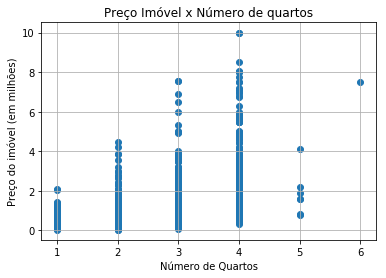

In [19]:
x2 =  data.loc[:,['Rooms']]
y2 =  a
plt.xlabel('Número de Quartos')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x Número de quartos')
plt.scatter(x2,y2)
plt.grid(True)

In [20]:
data['Price'].corr(data['Rooms'])

0.490254988091368

* Percebe-se que o preço tende a aumentar conforme aumentam os números de quartos. Uma possível explicação para o preço em apartamentos com 5 quartos ser menor é o fato de que estes podem estar em áreas onde o m² é menos valorizado, assim, apartamentos maiores poderão ter valores não tão altos. Isso também se mostra possível visto que a disparidade de preços em apartamentos com 3 e 4 quartos é muito grande. Porém, dito isso, a correlação ainda se mostra bem pequena, evidenciando o fato que há uma probabilidade de apartamentos com muitos quartos estarem em áreas menos valorizadas


### Boxplot Parking x Price


Text(0.5, 1.0, 'Preço Imóvel x Vagas no Estacionamento')

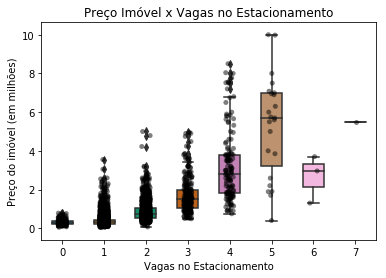

In [21]:
# make boxplot with Seaborn
bplot=sns.boxplot(y=a, x='Parking', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")
 
# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y=a, x='Parking', 
                   data=data, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')
plt.xlabel('Vagas no Estacionamento')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x Vagas no Estacionamento')

In [22]:
data["Parking"].corr(data["Price"])

0.7018488784055072

* Boxplot mostrando a relação entre o preço e as vagas no estacionamento. Aqui vemos que, por mais que tem uma presença forte de outliers nos apartamentos com menos vagas, vale lembrar que estes ainda acatam por outliers por serem consideravelmente menos imóveis que apresentam essas características. Além disso, a correlação de 0.7 é forte, porém não o melhor indicador.


### Boxplot Elevator x Price

Frequências absolutas por Elevador:
Sem    3748
Com    2664
Name: Elevator, dtype: int64 



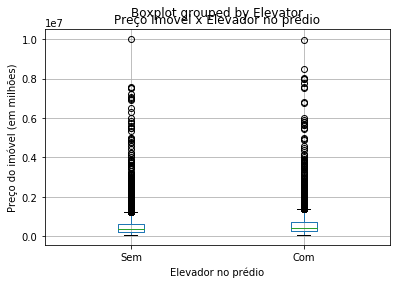

In [23]:
data.Elevator = data.Elevator.astype('category')
data.Elevator.cat.categories = (['Sem', 'Com'])

print('Frequências absolutas por Elevador:')
ut1 = data.Elevator.value_counts(sort=False).reindex(['Sem', 'Com'])
print(ut1,'\n')

data.boxplot(column="Price",by="Elevator")
plt.xlabel('Elevador no prédio')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x Elevador no prédio')
plt.show()


* Boxplot mostrando a relação entre o preço e se o imóvel possui ou não um elevador. Aqui vemos que, por mais que tem uma presença forte de outliers nos apartamentos com elevadores, vale lembrar que estes ainda acatam por outliers por serem consideravelmente menos imóveis que apresentam essas características.


### Scatterplot Suítes x Price

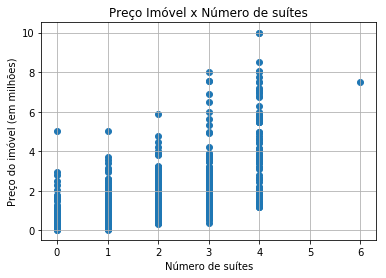

In [35]:
xsuite = data["Suites"]
ysuite = a
plt.xlabel('Número de suítes')
plt.ylabel('Preço do imóvel (em milhões)')
plt.title('Preço Imóvel x Número de suítes')
plt.scatter(xsuite, ysuite)
plt.grid(True)
plt.show()

In [25]:
xsuite.corr(ysuite)

0.6231768847987372

* Scatterplot mostrando a relação entre o número de suítes e o preço dos imóveis da base de dados estudada durante o projeto. Como pode-se perceber, conforme o número de suítes aumenta, o preço dos imóveis também aumentam.

## Classificador random forest

Já filtrada as variáveis obsoletas para o projeto, iremos utilizar da técnica de classificação random forest para encontrar padrões entre os imóveis listados

In [26]:
data.Price.describe()

count    6.412000e+03
mean     6.086241e+05
std      7.404515e+05
min      4.200000e+04
25%      2.500000e+05
50%      3.800000e+05
75%      6.790000e+05
max      1.000000e+07
Name: Price, dtype: float64

In [27]:
data['Classification']='Muito Alto'
data.loc[(data.Price > 380000) & (data.Price <= 679000), "Classification"] = 'Alto' 
data.loc[(data.Price > 250000) & (data.Price <= 380000), "Classification"] = 'Médio' 
data.loc[(data.Price <= 250000), "Classification"] = 'Baixo' 

In [28]:
data.Classification.value_counts(True)

Baixo         0.260761
Muito Alto    0.249688
Alto          0.245633
Médio         0.243918
Name: Classification, dtype: float64

In [29]:
x = data[['Size', 'Condo', 'Rooms', 'Toilets', 'Suites', 'Swimming Pool']]
y = data['Classification']

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=RANDOM_SEED)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Acurácia: {}'.format(accuracy_score(y_test, y_pred)))

Acurácia: 0.6990644490644491


In [32]:
matriz = pd.crosstab(y_test, y_pred, normalize = 'index')
matriz

col_0,Alto,Baixo,Muito Alto,Médio
Classification,,,,
Alto,0.607798,0.043578,0.153670,0.194954
Baixo,0.022514,0.797373,0.000000,0.180113
Muito Alto,0.145877,0.002114,0.837209,0.014799
Médio,0.238589,0.209544,0.014523,0.537344


## Matriz de Confusão

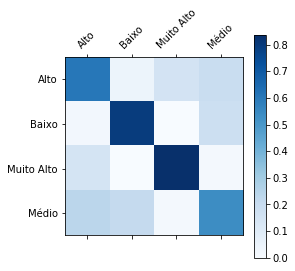

In [33]:
def plot_confusion_matrix(df_confusion, cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)

plot_confusion_matrix(matriz)

* Como pode-se observar no gráfico da matriz de confusão plotado acima, o classificador tem uma eficácia muito boa ao obter resultados **Verdadeiros-Verdadeiros** ( Quadrados de cor mais escura observado na diagonal do quadrado), principalmente ao classifcar imóveis categorizados como Baixo e Muito Alto. Além disso, a quantidade de **Falsos-Verdadeiros** obtidas também foi muito satisfatória, devido ao alto índice de acerto que pode ser observado nos quadrados brancos em volta da diagonal principal do gráfico. Em contra partida, embora exista classificações **Verdadeiro-Falso** ( Podendo ser  observados nos quadrados de cor mais acizentada nas bordas do gráfico), são números muitos pequenos sendo quase nulos (Quadrado Branco), confirmando assim que o classificador comete poucos erros.

## Árvore de decisão do classificador


In [34]:
dotfile = open('dtree2.dot', 'w')
# Extract single tree
estimator = model.estimators_[1]

# Export as dot file
export_graphviz(estimator, out_file=dotfile, 
                feature_names = ['Size', 'Condo', 'Rooms', 'Toilets', 'Suites', 'Swimming Pool'],
                class_names = ['Muito Alto', 'Alto', 'Médio', 'Baixo'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'dtree2.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#Ainda com problema.
#O código não está conseguindo achar o caminho da imagem no carregador.

FileNotFoundError: [WinError 2] O sistema não pode encontrar o arquivo especificado

* Imagem mostrando como o processo de classificação acontece e a linha de raciocínio que o classificador segue para categorizar cada imóvel do banco de dados

## Fontes:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html<br>
https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c